In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error
from math import sqrt
# ---------------------------
# 1. Load and Clean Dataset
# ---------------------------
data = pd.read_csv("AirQuality.csv", sep=';', decimal=',') 

In [3]:
data.dropna(axis=0, how='all', inplace=True)

data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)
data.set_index('Date', inplace=True)
data = data.drop('Time',axis=1)
data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
Date,,,,,,,,,,,,,,,
2004-03-10,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
2004-03-10,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2004-03-10,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
2004-03-10,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
2004-03-10,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,NaN,NaN
2005-04-04,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,NaN,NaN
2005-04-04,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,NaN,NaN


In [5]:
data.replace(-200, pd.NA, inplace=True)  # Mark -200 as missing
data.fillna(method='ffill', inplace=True)  # Forward fill missing values

C:\Users\maddu\AppData\Local\Temp\ipykernel_28988\3470400219.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values
C:\Users\maddu\AppData\Local\Temp\ipykernel_28988\3470400219.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [7]:
# Keep only numeric columns
data = data.select_dtypes(include=['number'])
data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
Date,,,,,,,,,,,,,,,
2004-03-10,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
2004-03-10,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2004-03-10,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
2004-03-10,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
2004-03-10,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04,3.1,1314.0,275.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,NaN,NaN
2005-04-04,2.4,1163.0,275.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,NaN,NaN
2005-04-04,2.4,1142.0,275.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,NaN,NaN


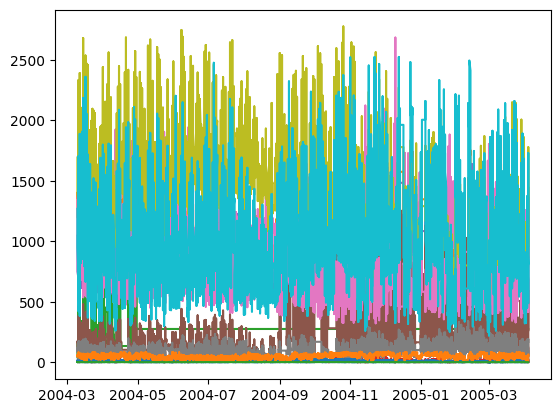

In [9]:
plt.plot(data)
plt.show()

In [55]:
data = data[['CO(GT)','NMHC(GT)','NOx(GT)','NO2(GT)']]

data_2004 = data[data.index.year == 2004]
data_2004

,CO(GT),NMHC(GT),NOx(GT),NO2(GT)
Date,,,,
2004-03-10,2.6,150.0,166.0,113.0
2004-03-10,2.0,112.0,103.0,92.0
2004-03-10,2.2,88.0,131.0,114.0
2004-03-10,2.2,80.0,172.0,122.0
2004-03-10,1.6,51.0,131.0,116.0
...,...,...,...,...
2004-12-31,1.2,275.0,165.0,101.0
2004-12-31,1.2,275.0,165.0,101.0
2004-12-31,1.2,275.0,165.0,101.0


In [138]:
ozone_df['Date'] = pd.to_datetime(ozone_df['Date'], errors='coerce', dayfirst=True)
ozone = ozone_df[['WSR0', 'WSR1', 'Date']].dropna(subset=['Date'])
ozone.set_index('Date', inplace=True)
ozone

,WSR0,WSR1
Date,,
1998-01-01,0.8,1.8
1998-02-01,2.8,3.2
1998-03-01,2.9,2.8
1998-04-01,4.7,3.8
1998-05-01,2.6,2.1
...,...,...
2004-04-12,0.3,0.4
2004-05-12,1.0,1.4
2004-06-12,0.8,0.8


In [79]:
ozone_2004 = ozone[ozone.index.year == 2004]
ozone_2004

,WSR0,WSR1
Date,,
2004-01-01,1.0,1.5
2004-02-01,4.8,4.1
2004-03-01,2.3,1.6
2004-04-01,6.7,5.1
2004-05-01,1.6,1.2
...,...,...
2004-04-12,0.3,0.4
2004-05-12,1.0,1.4
2004-06-12,0.8,0.8


In [81]:
data_2004_unique = data_2004[~data_2004.index.duplicated(keep='first')]
ozone_2004_unique = ozone_2004[~ozone_2004.index.duplicated(keep='first')]

df_combined = pd.concat([data_2004_unique, ozone_2004_unique], axis=1, join='inner')

df_combined

,CO(GT),NMHC(GT),NOx(GT),NO2(GT),WSR0,WSR1
Date,,,,,,
2004-03-10,2.6,150.0,166.0,113.0,0.8,0.9
2004-03-11,1.2,31.0,62.0,77.0,0.7,0.8
2004-03-12,1.7,55.0,122.0,97.0,0.9,0.4
2004-04-01,1.6,106.0,96.0,86.0,6.7,5.1
2004-04-02,2.0,157.0,126.0,104.0,0.2,1.8
...,...,...,...,...,...,...
2004-12-07,1.4,275.0,191.0,74.0,0.6,1.2
2004-12-08,1.7,275.0,194.0,84.0,1.3,1.1
2004-12-09,1.9,275.0,241.0,100.0,1.4,1.2


In [89]:
from statsmodels.tsa.api import VAR

In [144]:
VAR?

Init signature: VAR(endog, exog=None, dates=None, freq=None, missing='none')
Docstring:     
Fit VAR(p) process and do lag order selection

.. math:: y_t = A_1 y_{t-1} + \ldots + A_p y_{t-p} + u_t

Parameters
----------
endog : array_like
    2-d endogenous response variable. The independent variable.
exog : array_like
    2-d exogenous variable.
dates : array_like
    must match number of rows of endog

References
----------
Lütkepohl (2005) New Introduction to Multiple Time Series Analysis
File:           c:\users\maddu\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py
Type:           type
Subclasses:     

In [146]:
model = VAR(df_combined[['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']],exog=df_combined[['WSR0', 'WSR1']])
results = model.fit()

C:\Users\maddu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [148]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, May, 2025
Time:                     10:17:12
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    23.1909
Nobs:                     106.000    HQIC:                   22.7725
Log likelihood:          -1765.46    FPE:                5.84065e+09
AIC:                      22.4873    Det(Omega_mle):     4.52242e+09
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               1.208690         0.662670            1.824           0.068
WSR0               -0.000076         0.250775           -0.000           1.000
WSR1               -0.072551         0.262374           -0.277     

In [150]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX

In [165]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger Causality Test on 'WSR0' causing 'WSR1'
print('WSR0 causes WSR1')
print('-----------------')

# Specify the max lag order (typically you can choose based on domain knowledge or use AIC/BIC)
max_lag = 5  # Adjust this as needed

granger1 = grangercausalitytests(df_combined[['WSR0', 'WSR1']], max_lag, verbose=True)


WSR0 causes WSR1
-----------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0026  , p=0.9597  , df_denom=103, df_num=1
ssr based chi2 test:   chi2=0.0026  , p=0.9590  , df=1
likelihood ratio test: chi2=0.0026  , p=0.9590  , df=1
parameter F test:         F=0.0026  , p=0.9597  , df_denom=103, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0003  , p=0.9997  , df_denom=100, df_num=2
ssr based chi2 test:   chi2=0.0006  , p=0.9997  , df=2
likelihood ratio test: chi2=0.0006  , p=0.9997  , df=2
parameter F test:         F=0.0003  , p=0.9997  , df_denom=100, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0323  , p=0.9922  , df_denom=97, df_num=3
ssr based chi2 test:   chi2=0.1037  , p=0.9914  , df=3
likelihood ratio test: chi2=0.1037  , p=0.9914  , df=3
parameter F test:         F=0.0323  , p=0.9922  , df_denom=97, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F tes

C:\Users\maddu\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [113]:
from statsmodels.tsa.statespace.varmax import VARMAX

# Fit a VARMAX model
var_model = VARMAX(df_combined[['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']], 
                   order=(10, 0), 
                   exog=df_combined[['WSR0', 'WSR1']])

# Fit the model
var_results = var_model.fit()

C:\Users\maddu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\maddu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [116]:
var_results.summary()

Dep. Variable:,"['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']",No. Observations:,107
Model:,VARX(10),Log Likelihood,-1695.467
,+ intercept,AIC,3754.934
Date:,"Tue, 06 May 2025",BIC,4241.389
Time:,10:03:26,HQIC,3952.136
Sample:,0,,
,- 107,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.53, 0.15, 0.36, 0.16",Jarque-Bera (JB):,"5.60, 41.68, 65.31, 1.82"
Prob(Q):,"0.47, 0.70, 0.55, 0.68",Prob(JB):,"0.06, 0.00, 0.00, 0.40"
Heteroskedasticity (H):,"2.72, 0.34, 3.07, 0.98",Skew:,"0.47, -0.30, 0.92, -0.18"


In [124]:
n_forecast=12
pred=var_results.get_prediction()
preds=pred.predicted_mean
preds.columns=['CO(GT)_p',	'NMHC(GT)_p',	'NOx(GT)_p',	'NO2(GT)_p']
preds

,CO(GT)_p,NMHC(GT)_p,NOx(GT)_p,NO2(GT)_p
Date,,,,
2004-03-10,2.449755,259.790759,245.772998,99.554547
2004-03-11,2.226081,192.817093,174.717712,104.633022
2004-03-12,1.801142,128.919664,109.484106,80.148919
2004-04-01,1.763673,116.185289,187.927343,123.395898
2004-04-02,1.898686,194.540714,89.463312,84.328498
...,...,...,...,...
2004-12-07,0.641751,277.783002,130.252807,65.231548
2004-12-08,1.806051,261.720591,240.272275,93.487340
2004-12-09,2.364896,275.885497,287.072021,95.144931


In [130]:
testvspred=pd.concat([df_combined,preds],axis=1)
testvspred = testvspred.drop(['WSR0','WSR1'],axis=1)
testvspred

,CO(GT),NMHC(GT),NOx(GT),NO2(GT),CO(GT)_p,NMHC(GT)_p,NOx(GT)_p,NO2(GT)_p
Date,,,,,,,,
2004-03-10,2.6,150.0,166.0,113.0,2.449755,259.790759,245.772998,99.554547
2004-03-11,1.2,31.0,62.0,77.0,2.226081,192.817093,174.717712,104.633022
2004-03-12,1.7,55.0,122.0,97.0,1.801142,128.919664,109.484106,80.148919
2004-04-01,1.6,106.0,96.0,86.0,1.763673,116.185289,187.927343,123.395898
2004-04-02,2.0,157.0,126.0,104.0,1.898686,194.540714,89.463312,84.328498
...,...,...,...,...,...,...,...,...
2004-12-07,1.4,275.0,191.0,74.0,0.641751,277.783002,130.252807,65.231548
2004-12-08,1.7,275.0,194.0,84.0,1.806051,261.720591,240.272275,93.487340
2004-12-09,1.9,275.0,241.0,100.0,2.364896,275.885497,287.072021,95.144931


<Axes: xlabel='Date'>

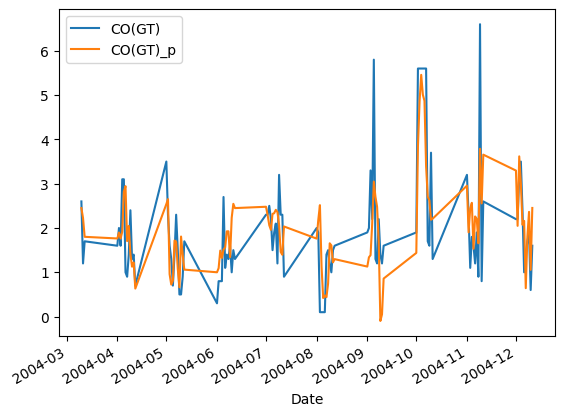

In [132]:
testvspred[['CO(GT)','CO(GT)_p']].plot()

In [136]:
from sklearn.metrics import mean_squared_error
mean_squared_error (testvspred['CO(GT)'],testvspred['CO(GT)_p'])

0.8745616726158256

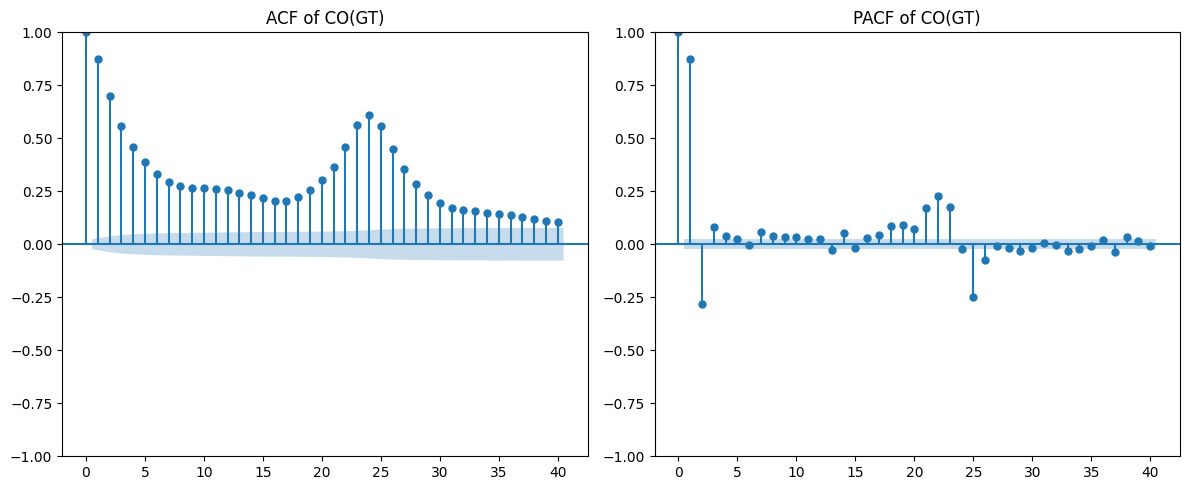

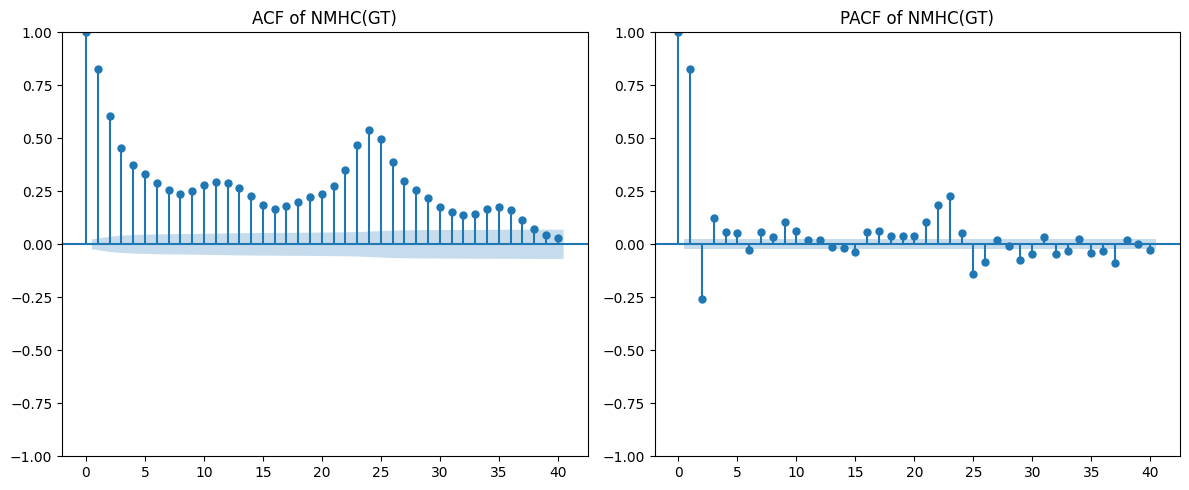

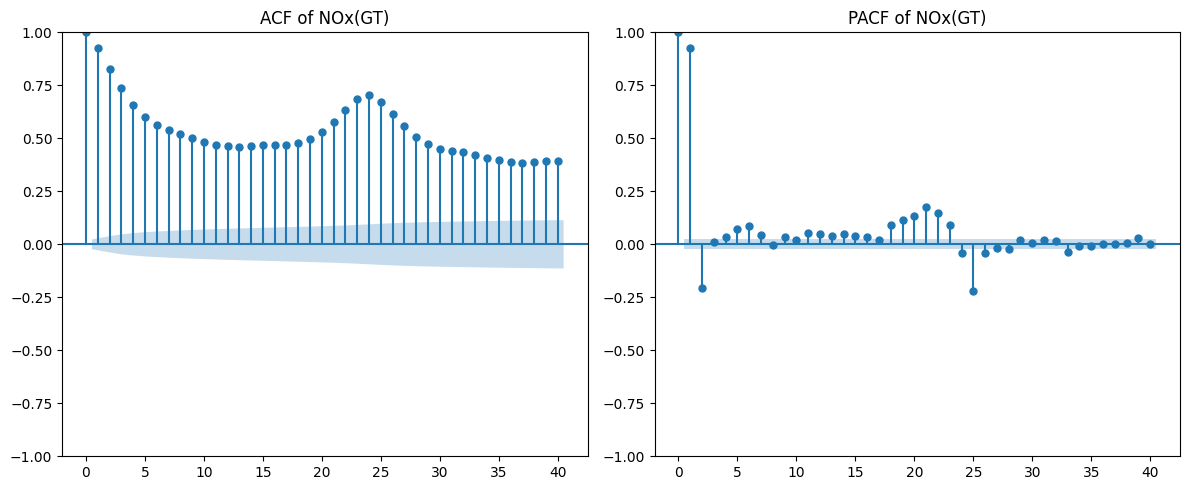

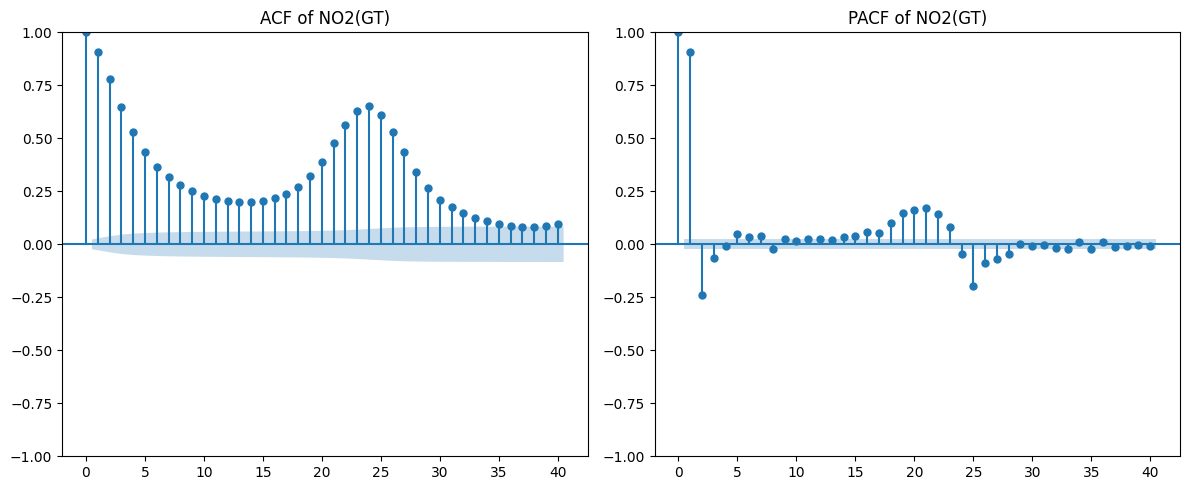

In [154]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for each selected variable
for column in data_2004.columns:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plot_acf(data_2004[column].dropna(), lags=40, ax=plt.gca())
    plt.title(f'ACF of {column}')
    
    plt.subplot(1, 2, 2)
    plot_pacf(data_2004[column].dropna(), lags=40, ax=plt.gca(), method='ywm')
    plt.title(f'PACF of {column}')
    
    plt.tight_layout()
    plt.show()



Summary Statistics:
            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean      2.082195  1102.730362   270.496740    10.190392     942.548253   
std       1.469801   219.588101    73.306853     7.565771     269.581368   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.000000   938.000000   275.000000     4.400000     733.000000   
50%       1.700000  1062.000000   275.000000     8.300000     911.000000   
75%       2.800000  1237.000000   275.000000    14.000000    1117.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    240.731217    832.742225   109.414877   1453.014535  1030.511916   
std     206.618453    255.709423    47.221662    347.434084   410.

C:\Users\maddu\AppData\Local\Temp\ipykernel_28988\2606241432.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\maddu\AppData\Local\Temp\ipykernel_28988\2606241432.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(method='ffill', inplace=True)


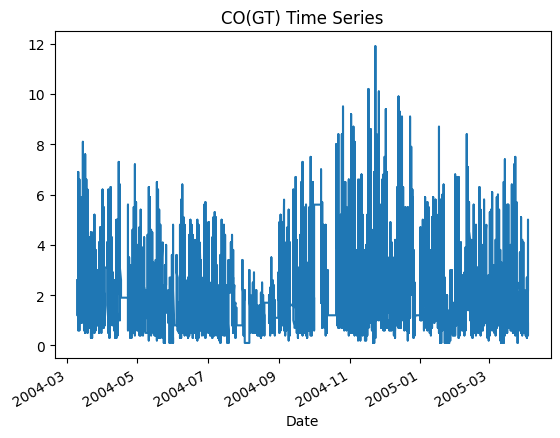

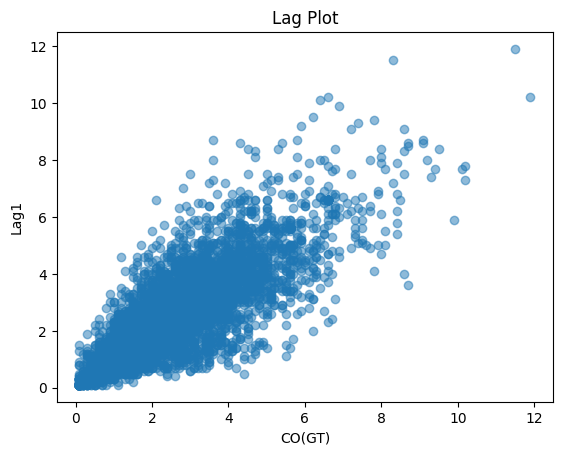

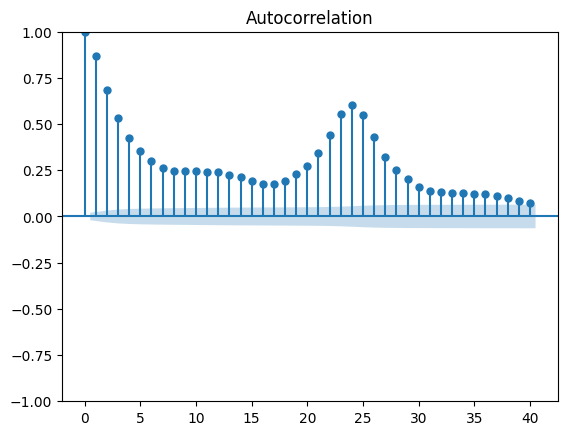

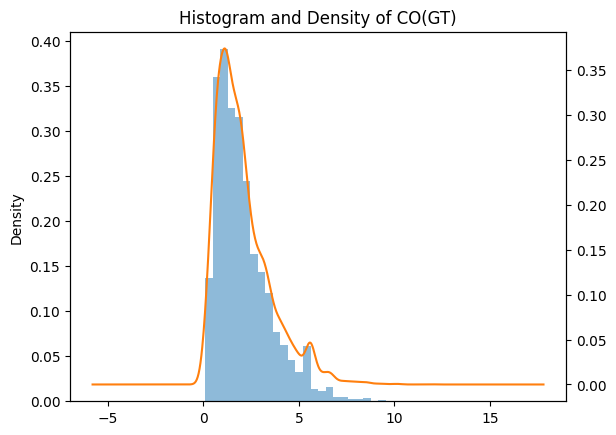

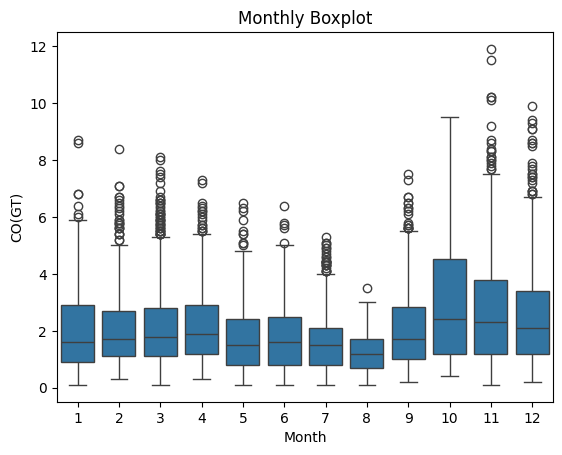

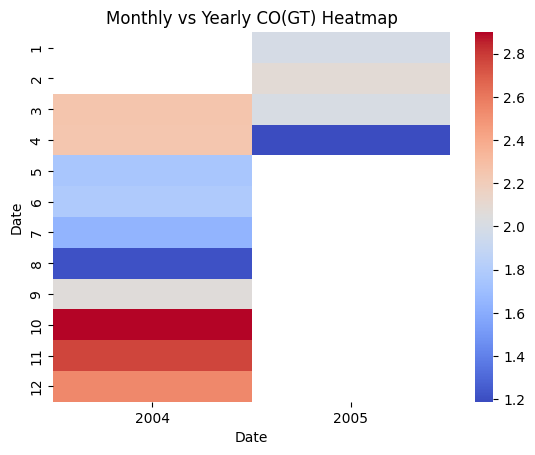

ADF Statistic: -9.423842514292385
p-value: 5.412774695135527e-16

After Differencing:
ADF Statistic: -20.085314828539172
p-value: 0.0


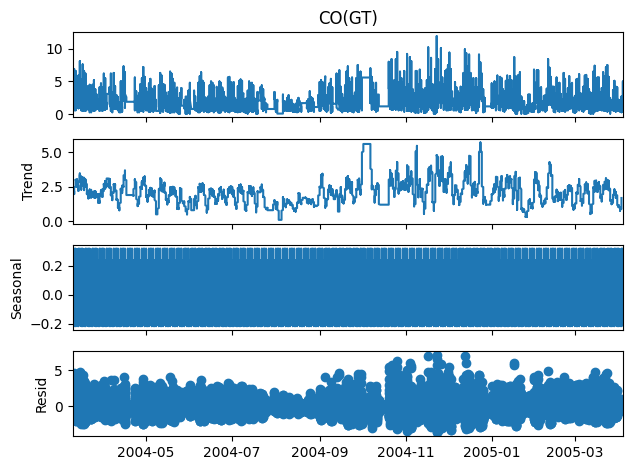

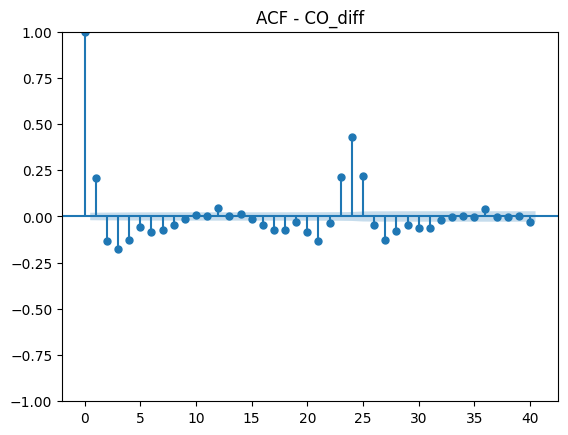

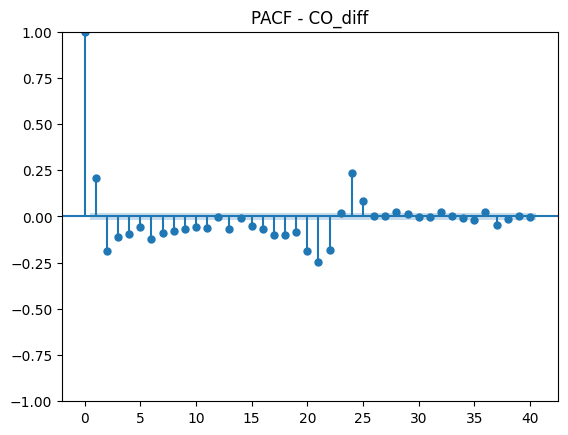

In [161]:

# Step 1: Load and Query Time-Series Data
import pandas as pd

data = pd.read_csv("AirQuality.csv", sep=';', decimal=',')
data.dropna(axis=0, how='all', inplace=True)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)
data.set_index('Date', inplace=True)
data.drop('Time', axis=1, inplace=True)
data.replace(-200, pd.NA, inplace=True)
data.fillna(method='ffill', inplace=True)
data = data.select_dtypes(include=['number'])


print("\nSummary Statistics:")
print(data.describe())



# Step 2: Feature Engineering
data['Month'] = data.index.month
data['Weekday'] = data.index.dayofweek
data['Temp_Lag1'] = data['CO(GT)'].shift(1)
data['Temp_RollingMean7'] = data['CO(GT)'].rolling(window=7).mean()
data['Temp_ExpandingMean'] = data['CO(GT)'].expanding().mean()
data.head()



# Step 3: Exploring Temporal Relationships
import matplotlib.pyplot as plt
import seaborn as sns

# a. Line plot
data['CO(GT)'].plot(title="CO(GT) Time Series")
plt.show()

# b. Scatter plot of lagged values
plt.scatter(data['CO(GT)'], data['Temp_Lag1'], alpha=0.5)
plt.title("Lag Plot")
plt.xlabel("CO(GT)")
plt.ylabel("Lag1")
plt.show()

# c. ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['CO(GT)'].dropna(), lags=40)
plt.show()

# d. Histogram and density plot
data['CO(GT)'].plot(kind='hist', bins=30, alpha=0.5, density=True)
data['CO(GT)'].plot(kind='kde', secondary_y=True)
plt.title("Histogram and Density of CO(GT)")
plt.show()

# e. Boxplot for months
sns.boxplot(x="Month", y="CO(GT)", data=data.reset_index())
plt.title("Monthly Boxplot")
plt.show()

# f. Heatmap of yearly temperature variations
data['Year'] = data.index.year
pivot = data.pivot_table(values='CO(GT)', index=data.index.month, columns=data.index.year)
sns.heatmap(pivot, cmap="coolwarm")
plt.title("Monthly vs Yearly CO(GT) Heatmap")
plt.show()



# Step 4: Resampling and Interpolation
'''
# a. Upsample to hourly frequency
upsampled = data['CO(GT)'].resample('H').asfreq()
print("Upsampled data with NaNs:", upsampled.head())

# b. Linear interpolation
interpolated = upsampled.interpolate(method='linear')
print("Interpolated data:", interpolated.head())

# c. Downsample to monthly frequency
monthly_avg = data['CO(GT)'].resample('M').mean()
print("Monthly averages:", monthly_avg.head())

# d. Group by year and compute annual mean
annual_mean = data['CO(GT)'].resample('Y').mean()
print("Annual mean temperatures:", annual_mean)

'''

# Step 5: Stationarity, Trend, and Seasonality
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# ADF Test
result = adfuller(data['CO(GT)'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Differencing if needed
data['CO_diff'] = data['CO(GT)'].diff()
result_diff = adfuller(data['CO_diff'].dropna())
print('\nAfter Differencing:')
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

# Decomposition
decomposition = seasonal_decompose(data['CO(GT)'].dropna(), model='additive', period=30)
decomposition.plot()
plt.show()



# Step 6: ACF and PACF
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(data['CO_diff'].dropna(), lags=40)
plt.title("ACF - CO_diff")
plt.show()

plot_pacf(data['CO_diff'].dropna(), lags=40, method='ywm')
plt.title("PACF - CO_diff")
plt.show()
